In [0]:
!unzip "/content/gdrive/My Drive/Deep Learning/Assignment/Graded_4/dog-breed-identification.zip"


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [0]:
pd.__version__


'0.20.3'

In [0]:
from sklearn.linear_model import LogisticRegression


In [0]:
start = dt.datetime.now()


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/Deep Learning/Assignment/Graded_4/keras-pretrained-models"

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Kuszma.JPG
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [0]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [0]:
!cp '/content/drive/My Drive/Deep Learning/Assignment/Graded_4/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' ~/.keras/models/
!cp '/content/drive/My Drive/Deep Learning/Assignment/Graded_4/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' ~/.keras/models/
!cp '/content/drive/My Drive/Deep Learning/Assignment/Graded_4/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5' ~/.keras/models/
!cp '/content/drive/My Drive/Deep Learning/Assignment/Graded_4/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5' ~/.keras/models/
!cp "/content/drive/My Drive/Deep Learning/Assignment/Graded_4/keras-pretrained-models/imagenet_class_index.json" ~/.keras/models/
!cp "/content/drive/My Drive/Deep Learning/Assignment/Graded_4/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels.h5" ~/.keras/models/



In [0]:
!ls ~/.keras/models


imagenet_class_index.json
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [0]:
inputsize = 224
numclasses = 16
seed = 1987
labels = pd.read_csv("/content/drive/My Drive/Deep Learning/Assignment/Graded_4/labels.csv")
sample_submission = pd.read_csv("/content/drive/My Drive/Deep Learning/Assignment/Graded_4/sample_submission.csv")
print(len(listdir("/content/drive/My Drive/Deep Learning/Assignment/Graded_4/train")), len(labels))
print(len(listdir("/content/drive/My Drive/Deep Learning/Assignment/Graded_4/test")), len(sample_submission))

10222 10222
10357 10357


In [0]:
pip install pandas==0.20.3

     |████████████████████████████████| 24.5MB 138kB/s 
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.20.3 which is incompatible.
ERROR: seaborn 0.10.1 has requirement pandas>=0.22.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: pandas-datareader 0.8.1 has requirement pandas>=0.21, but you'll have pandas 0.20.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.20.3 which is incompatible.
ERROR: featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: fbprophet 0.6 has requirement pandas>=0.23.4, but you'll have pandas 0.20.3 which is incompatible.
  Found existing installation: pandas 1.0.3
    Uninsta

In [0]:
breedlist = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(numclasses).index)
labels = labels[labels['breed'].isin(breedlist)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
pivotlabel = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=seed)
rnd = np.random.random(len(labels))
trainindex = rnd < 0.8
validationindex = rnd >= 0.8
y_train = pivotlabel[breedlist].values
ytr = y_train[trainindex
yv = y_train[validationindex]

In [0]:
def readimage(imgid, trainortest, size):
   
    img = image.load_img(join("/content/drive/My Drive/Deep Learning/Assignment/Graded_4/train/", '%s.jpg' % imgid), target_size=size)
    img = image.img_to_array(img)
    return img

In [0]:
labels

,id,breed,target,rank
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,1,1.0
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,1,1.0
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,1,1.0
29,00bee065dcec471f26394855c5c2f3de,cairn,1,1.0
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,1,1.0
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,1,1.0
70,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed,1,1.0
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound,1,2.0
80,01ee3c7ff9bcaba9874183135877670e,entlebucher,1,1.0
88,021b5a49189665c0442c19b5b33e8cf1,entlebucher,1,2.0


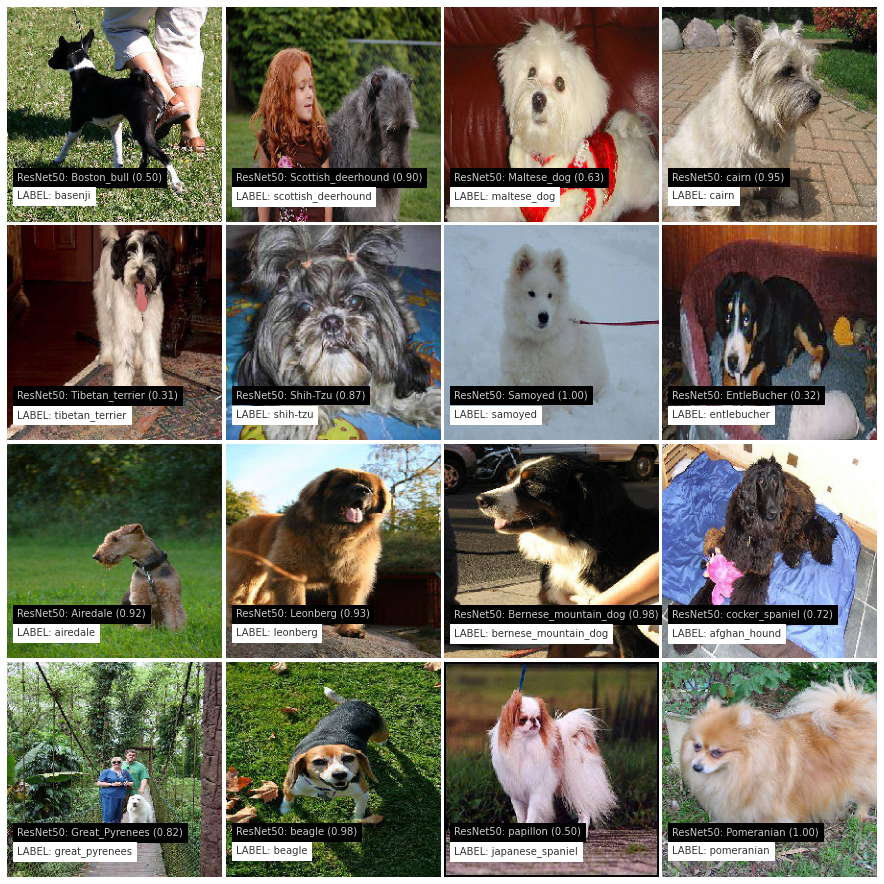

In [0]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(numclasses))
i = int(np.ceil(1. * numclasses / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]

    img = readimage(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

In [0]:
inputsize = 224
pooling = 'avg'
x_train = np.zeros((len(labels), inputsize, inputsize, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = readimage(img_id, 'train', (inputsize, inputsize))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('training shape: {} size: {:,}'.format(x_train.shape, x_train.size))


1777it [13:31,  2.19it/s]

Train Images shape: (1777, 224, 224, 3) size: 267,488,256


In [0]:
Xtr = x_train[trainindex]
Xv = x_train[validindex]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vggbottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
trainvgg = vggbottleneck.predict(Xtr, batch_size=32, verbose=1)
validvggbf = vggbottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(trainvgg.shape, trainvgg.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(validvggbf.shape, validvggbf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
368/368 [==============================] - 3s 8ms/step
VGG train bottleneck features shape: (1409, 512) size: 721,408
VGG valid bottleneck features shape: (368, 512) size: 188,416


In [0]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=seed)
logreg.fit(trainvgg, (ytr * range(numclasses)).sum(axis=1))
probvalid = logreg.predict_proba(validvggbf)
predvalid = logreg.predict(validvggbf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, probvalid)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(numclasses)).sum(axis=1), predvalid)))

Validation VGG LogLoss 0.35203215090305023
Validation VGG Accuracy 0.9184782608695652


In [0]:
inputsize = 299
pooling = 'avg'
x_train = np.zeros((len(labels), inputsize, inputsize, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = readimage(img_id, 'train', (inputsize, inputsize))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:09, 180.77it/s]

Train Images shape: (1777, 299, 299, 3) size: 476,596,731


In [0]:
Xtrain = x_train[trainindex]
Xv = x_train[validationindex]
print((Xtrain.shape, Xv.shape, ytr.shape, yv.shape))
xceptionbottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=pooling)
trainxbf = xceptionbottleneck.predict(Xtrain, batch_size=32, verbose=1)
valid_x_bf = xceptionbottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(trainxbf.shape, trainxbf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(validxbf.shape, validxbf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - 6s 17ms/step
Xception train bottleneck features shape: (1409, 2048) size: 2,885,632
Xception valid bottleneck features shape: (368, 2048) size: 753,664


In [0]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=seed)
logreg.fit(trainxbf, (ytr * range(numclasses)).sum(axis=1))
probvalid = logreg.predict_proba(validxbf)
predvalid = logreg.predict(validxbf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, probvalid)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(numclasses)).sum(axis=1), predvalid)))

Validation Xception LogLoss 0.06826042240226965
Validation Xception Accuracy 0.9809782608695652


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
Xtrain = x_train[trainindex]
Xv = x_train[validationindex]
print((Xtrain.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=pooling)
trainibf = inception_bottleneck.predict(Xtrain, batch_size=32, verbose=1)
validibf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(trainibf.shape, trainibf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(validibf.shape, validibf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - 4s 11ms/step
InceptionV3 train bottleneck features shape: (1409, 2048) size: 2,885,632
InceptionV3 valid bottleneck features shape: (368, 2048) size: 753,664


In [0]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=seed)
logreg.fit(trainibf, (ytr * range(numclasses)).sum(axis=1))
probvalid = logreg.predict_proba(validibf)
predvalid = logreg.predict(validibf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
print('Validation Inception LogLoss {}'.format(log_loss(yv, probvalid)))
print('Validation Inception Accuracy {}'.format(accuracy_score((yv * range(numclasses)).sum(axis=1), predvalid)))

Validation Inception LogLoss 0.08050283679980567
Validation Inception Accuracy 0.967391304347826


In [0]:
X = np.hstack([trainxbf, trainibf])
V = np.hstack([validxbf, validibf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=seed)
logreg.fit(X, (ytr * range(numclasses)).sum(axis=1))
probvalid = logreg.predict_proba(V)
predvalid = logreg.predict(V)
print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, probvalid)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((yv * range(numclasses)).sum(axis=1), predvalid)))

Full train bottleneck features shape: (1409, 4096) size: 5,771,264
Full valid bottleneck features shape: (368, 4096) size: 1,507,328
Validation Xception + Inception LogLoss 0.07089607887119284
Validation Xception + Inception Accuracy 0.9755434782608695


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


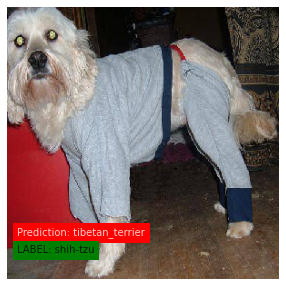

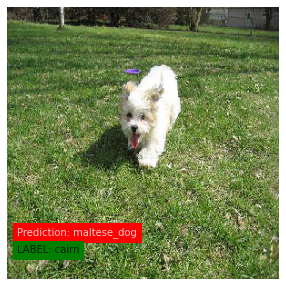

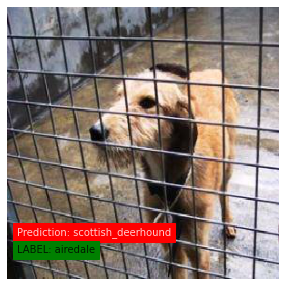

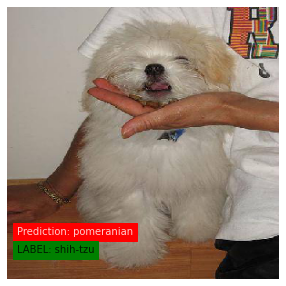

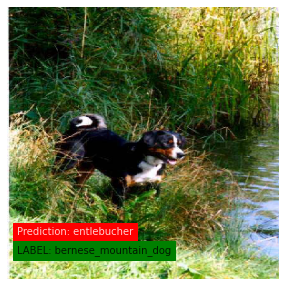

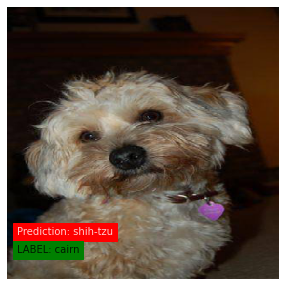

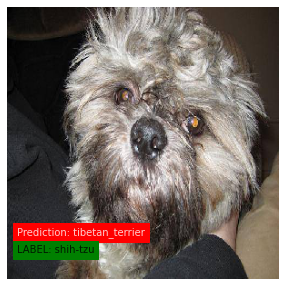

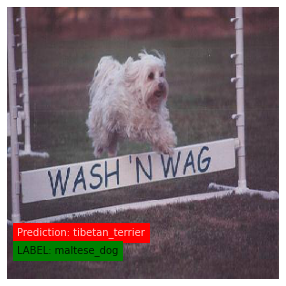

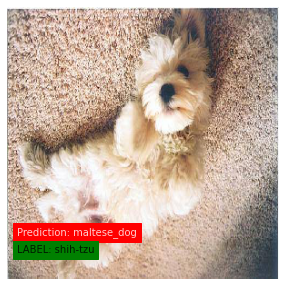

In [0]:
breedsvalid = (yv * range(numclasses)).sum(axis=1)
errorindex = (breedsvalid != predvalid)
for img_id, breed, pred in zip(labels.loc[validationindex, 'id'].values[errorindex],
                                [breedlist[int(b)] for b in predvalid[errorindex]],
                                [breedlist[int(b)] for b in breedsvalid[errorindex]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = readimage(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()       